In [1]:
from pathlib import Path

import gzip
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

from tinygrad import optim
from tinygrad.tensor import Tensor

In [2]:
root_dir = Path('.').resolve(strict=True).parent
data_dir = root_dir / 'data'

In [3]:
def fetch(file_name):
    with gzip.open(data_dir / file_name, 'rb') as file:
        array = np.frombuffer(file.read(), np.uint8)
    return array.copy()


x_train = fetch('train-images-idx3-ubyte.gz')[16:].reshape((-1, 28 * 28)).astype(np.float32)
y_train = fetch('train-labels-idx1-ubyte.gz')[8:]
x_test = fetch('t10k-images-idx3-ubyte.gz')[16:].reshape((-1, 28 * 28)).astype(np.float32)
y_test = fetch('t10k-labels-idx1-ubyte.gz')[8:]

In [4]:
bs = 128
lr = 0.001
epochs = 1000

In [5]:
# https://github.com/geohot/tinygrad/blob/c162e748f59605af5134364b200c3ef0dc6ac342/extra/training.py
def sparse_categorical_crossentropy(out, Y):
    num_classes = out.shape[-1]
    YY = Y.flatten()
    y = np.zeros((YY.shape[0], num_classes), np.float32)
    # correct loss for NLL, torch NLL loss returns one per row
    y[range(y.shape[0]),YY] = -1.0*num_classes
    y = y.reshape(list(Y.shape)+[num_classes])
    y = Tensor(y)
    return out.mul(y).mean()


loss_func = sparse_categorical_crossentropy

In [6]:
# Not a CNN
class TinyCNN:
    def __init__(self):
        self.l1 = Tensor.uniform(784, 256)
        self.l2 = Tensor.uniform(256, 128)
        self.l3 = Tensor.uniform(128, 10)

    def forward(self, x):
        x = x.dot(self.l1).relu()
        x = x.dot(self.l2).relu()
        x = x.dot(self.l3).logsoftmax()
        return x


model = TinyCNN()
opt = optim.Adam([model.l1, model.l2], lr=lr)

loss 0.64 accuracy 0.75:   0%|          | 5/1000 [00:00<00:21, 45.95it/s]

warning, (128, 10) isn't float32


loss 0.08 accuracy 0.96: 100%|██████████| 1000/1000 [00:19<00:00, 52.38it/s]


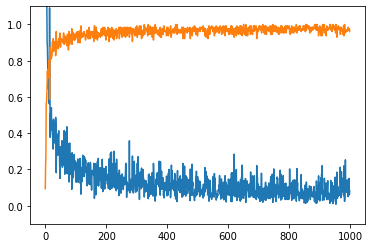

In [7]:
accuracies = []
losses = []

for epoch in (t := trange(epochs)):
    samp = np.random.randint(0, len(x_train), size=(bs))
    x = Tensor(x_train[samp])
    y = y_train[samp]

    out = model.forward(x)
    loss = loss_func(out, y)

    opt.zero_grad()
    loss.backward()
    opt.step()
    
    cat = np.argmax(out.data, axis=-1)
    accuracy = (cat == y).mean()
    loss = loss.data

    losses.append(loss)
    accuracies.append(accuracy)
    t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))

plt.ylim(-0.1, 1.1)
plt.plot(losses)
plt.plot(accuracies)

In [8]:
out = model.forward(Tensor(x_test)).data
pred = np.argmax(out, axis=-1)
(pred == y_test).mean()

0.9699